In [58]:
from pathlib import Path
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from gym_recording_modified.playback import get_recordings
import seaborn as sns
from scipy.stats import sem

In [5]:
def plot_timesteps(params: np.array, data: np.array, row=None, col=None, plot=None, xlabel='', ylabel='', rowdict={}, coldict={}):
    """
    General-use function for plotting a variable over time

    args: 
        params : np.array shape (num_runs, num_params) with parameters for each run
        data : np.array shape (num_runs, num_timesteps) with data
        row : index of parameters, this function will generate a subplot for each unique setting
        col : index of parameters, this function Will generate a subplot for each unique setting
        plot : index of parameters, for which a new line will be added to a subplot for each unique value
        
    """

    nrows = np.unique(params[:, row]).shape[0]
    ncols = np.unique(params[:, col]).shape[0]

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, squeeze=False)

    row_idx = 0
    for row_param in np.unique(params[:, row]):
        col_idx = 0
        for col_param in np.unique(params[:, col]):
            for plot_param in np.unique(params[:, plot]):
                inds = np.where(
                    (params[:, row]==row_param) & 
                    (params[:, col]==col_param) & 
                    (params[:, plot]==plot_param))
                

                data_ = np.mean(data[inds], axis=0) # data to plot
                
                ax = axs[row_idx, col_idx]
                ax.plot(data_)
                ax.set_title('%s, %s' % (rowdict.get(row_param, row_param), coldict.get(col_param, col_param)))
                ax.set_xlabel(xlabel)
                ax.set_ylabel(ylabel)

            
            col_idx += 1
        row_idx += 1

    fig.tight_layout()

In [52]:
def plot_episode_len(params: np.array, data: np.array, row=None, col=None, plot=None, xlabel='', ylabel='', rowdict={}, coldict={}):
    """
    General-use function for plotting a episode length

    args: 
        params : np.array shape (num_runs, num_params) with parameters for each run
        data : np.array shape (num_runs, num_timesteps) with data
        row : index of parameters, this function will generate a subplot for each unique setting
        col : index of parameters, this function Will generate a subplot for each unique setting
        plot : index of parameters, for which a new line will be added to a subplot for each unique value
        
    """

    nrows = np.unique(params[:, row]).shape[0]
    ncols = np.unique(params[:, col]).shape[0]

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, squeeze=False)

    row_idx = 0
    for row_param in np.unique(params[:, row]):
        col_idx = 0
        for col_param in np.unique(params[:, col]):
            for plot_param in np.unique(params[:, plot]):
                inds = np.where(
                    (params[:, row]==row_param) & 
                    (params[:, col]==col_param) & 
                    (params[:, plot]==plot_param))
                
                ax = axs[row_idx, col_idx]
                for run_data in data[inds]:
                    if len(run_data) > 1:
                        ax.plot(np.arange(len(run_data)),  run_data)
                    else:
                        ax.scatter([0], run_data)
                   

                ax.set_title('%s, %s' % (rowdict.get(row_param, row_param), coldict.get(col_param, col_param)))
                ax.set_xlabel(xlabel)
                ax.set_ylabel(ylabel)

            
            col_idx += 1
        row_idx += 1

    fig.tight_layout()

In [56]:
def plot_avg_episode_length(params: np.array, data: np.array, categories=[], shapes=None,  plot=None, xlabel='', ylabel='', rowdict={}, coldict={}, tick_fmt=''):

    """
    General-use function for plotting a episode length

    args: 
        params : np.array shape (num_runs, num_params) with parameters for each run
        data : np.array shape (num_runs, num_timesteps) with data
        categories : list of indices of parameters. This will determine the categorical variables plotted
        shapes : index of parameters, will plot variables in this column with different shapes
    """


    param_categories = np.unique(params[:, categories], axis=0)
    shape_categories = np.unique(params[:, shapes])
    bar_width = (1 / len(shape_categories))*0.9

    colours = sns.cubehelix_palette(len(shape_categories), start=.5, rot=-.75).as_hex()
    colour_dict = {}

    for i in range(len(shape_categories)):
        colour_dict[shape_categories[i]] = colours[i]

    x_pos = 0 # center for a collection of bars

    labels = []
    for param_cat in param_categories:

        
        bar_positions = [(x_pos-0.5)+ (i*bar_width) for i in range(len(shape_categories))]
        
        for i in range(len(shape_categories)):
            bar_pos = bar_positions[i]
            shape_cat = shape_categories[i]
            inds = np.where((params[:, categories]==param_cat).all(axis=1) & (params[:, shapes]==shape_cat))

            data_ = np.hstack(data[inds])
           
            plt.bar(bar_pos, np.mean(data_), align='edge', width = bar_width, color=colour_dict[shape_cat])
            plt.errorbar(bar_pos+(bar_width/2), np.mean(data_),yerr=sem(data_), ecolor='black', capsize=3 )
        labels.append(tick_fmt % tuple(param_cat))

        x_pos += 1
            
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
   
    plt.legend(handles=     [mpatches.Patch(color=colour_dict[cat], label=cat) for cat in shape_categories])
    plt.xticks(np.arange(len(param_categories)), labels=labels, rotation=290)
    plt.tight_layout()

<ipython-input-59-7edbe6ee9703>:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(all_params),  np.array( all_episodes)


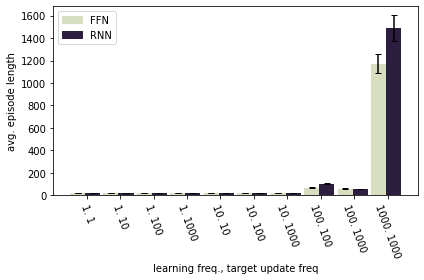

In [59]:
# plot episode lengths

root = Path('results')

def extract_epsisode_lengths(root: str, param_names: list,):
    """
    Extract epsiode lengths

    args
        root : directory where results are stored
        param_names : a list of parameters to extract for each run, stored in params.json 
        env: which environment to extract this for
    """

    all_episodes = []
    all_params = []

    for dir in root.iterdir():    
        params_file = dir/'params.json'               
        params = json.load(open(params_file))

    
                
        params_run  = [] # relevant parameters for a single run
        for p in param_names:
            params_run.append(params.get(p, None))

        all_params.append(params_run)
        episode_len= np.load(dir/"episode_lengths.npy")
        all_episodes.append(episode_len)

        
    
    return np.array(all_params),  np.array( all_episodes)

root = Path('results_tau_1')
params, episode_len = extract_epsisode_lengths(root, ['model_arch', 'env', 'seed', 'learning_freq', 'target_update_freq'])
env = 'envs:random_maze-v0'
inds = np.where( params[:, 1]==env)
params = params[inds]
episode_len = episode_len[inds]

plot_avg_episode_length(params, episode_len, categories=[3, 4], shapes=0, tick_fmt='%s. %s', xlabel='learning freq., target update freq', ylabel='avg. episode length')

In [53]:
def extract_rewards(root: str, param_names: list):
    """
    Extract rewards

    args
        root : directory where results are stored
        param_names : a list of parameters to extract for each run, stored in params.json 
    """

    all_rewards = []
    all_params = []

    for dir in root.iterdir():    
        params_file = dir/'params.json'               
        params = json.load(open(params_file))
        params_run  = [] # relevant parameters for a single run
        for p in param_names:
            params_run.append(params.get(p, None))

        all_params.append(params_run)
        rewards = get_recordings(dir, extract='rewards')['rewards']
        all_rewards.append(rewards)
        
    return np.array(all_params),  np.array(all_rewards)


params, rewards = extract_rewards(root, ['model_arch', 'env', 'seed'])